# Visualize the Optimization Process

In [67]:
from datetime import datetime
import itertools
import io

import numpy as np
import scipy.sparse as sp
import scipy as sc
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [68]:
dim = 2

In [69]:
STOP = 0.9999

In [70]:
class GradientNorm(tf.train.Optimizer):
    def __init__(self, learning_rate=0.1, use_locking=False, name="GradientNorm"):
        super().__init__(use_locking, name)
        self._lr = learning_rate
        
        # Tensor versions of the constructor arguments, created in _prepare().
        self._lr_t = None

    def _prepare(self):
        self._lr_t = tf.convert_to_tensor(self._lr, name="learning_rate")

    def _apply_dense(self, grad, var):
        lr_t = tf.cast(self._lr_t, var.dtype.base_dtype)
        var_update = tf.assign_sub(var, lr_t * grad / tf.norm(grad))
        
        return tf.group(*[var_update])

    def _apply_sparse(self, grad, var):
        raise NotImplementedError("Sparse gradient updates are not supported.")

In [85]:
def h_generator_tf(batch_size):
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h

def solve_gd_tensorflow(dim, h_generator, source, t):
    batch_size = 1
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.tile(tf.expand_dims(tf.constant(source, dtype='complex128'), axis=0), [batch_size, 1])
        target = tf.placeholder(dtype='complex128', shape=(batch_size, dim))

        h = h_generator(batch_size)

        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 2))

        target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
        fidelities = tf.abs(target_dot)
        loss = 1 - tf.reduce_mean(fidelities)

        optimizer = tf.train.MomentumOptimizer(momentum=0.0, learning_rate=2.0)
        gradients = optimizer.compute_gradients(loss)
        optimize_op = optimizer.minimize(loss)
    
    fidelities_val = []
    states_val = []
    gradients_val = []
    parameters_val = []
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        init_op = tf.global_variables_initializer()
        session.run(init_op)
        with tqdm() as qb:
            while len(fidelities_val) < 2 or fidelities_val[-1] < STOP and len(fidelities_val) < 1000:
                session.run(optimize_op, feed_dict={target: t})
                states_val.append(session.run(estimated_target, feed_dict={target: t}).squeeze())
                gradients_val.append(session.run(gradients, feed_dict={target: t}))
                parameters_val.append(session.run(h, feed_dict={target: t}).squeeze())
                fidelities_val.append(session.run(fidelities, feed_dict={target: t}).squeeze())
                qb.update()
                qb.set_description("fidelity: %f" % fidelities_val[-1])
                
    return fidelities_val, states_val, gradients_val, parameters_val

In [86]:
def h_generator_np():
    
    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    return [neardiag(i) for i in range(dim - 1)] + [diag(i) for i in range(dim)]

def solve_monotonic_numpy(dim, h_generator, source, target, start):
    opt = lambda h : abs(np.vdot(np.matmul(sc.linalg.expm(1j * h), source), target))
    diff = lambda d : (opt(h + eps * d) - opt(h)) / eps

    fmax = 1
    eps = 0.001
    
    rate = 2

    params = h_generator()
    h = start
    hd = None
    fs = []
    states = []
    
    statemax = 0.4
    state = 0.1
    with tqdm() as t:
        while len(fs) < 2 or fs[-1] < STOP and len(fs) < 1000:
            fs.append(opt(h))
            df = np.array([diff(p) for p in params])

            if np.linalg.norm(df) ** 2 == 0:
                print('non-rescue mode')
                return None, None, None
            
            hd = (fmax - fs[-1]) * sum([p * d for p, d in zip(params, df)]) / (np.linalg.norm(df)** 2 + 0.01 * np.linalg.norm(df))
            
            if opt(h + hd * state) > opt(h) and state < statemax:
                state *= rate
            if opt(h + hd * state) < opt(h):
                    state /= rate


            if abs(hd * state).sum() == 0:
                print('invalid derivative')
                return None, None, None

            h += hd * state
            states.append(state)
            t.update()
            t.set_description("fidelity: %f" % fs[-1])
    return states, fs, h

In [87]:
def solve_normgd_tensorflow(dim, h_generator, source, t):
    batch_size = 1
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.tile(tf.expand_dims(tf.constant(source, dtype='complex128'), axis=0), [batch_size, 1])
        target = tf.placeholder(dtype='complex128', shape=(batch_size, dim))

        h = h_generator(batch_size)

        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 2))

        target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
        fidelities = tf.abs(target_dot)
        loss = 1 - tf.reduce_mean(fidelities)

        optimizer = GradientNorm(learning_rate=0.5)
        gradients = optimizer.compute_gradients(loss)
        optimize_op = optimizer.minimize(loss)
    
    fidelities_val = []
    states_val = []
    gradients_val = []
    parameters_val = []
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        init_op = tf.global_variables_initializer()
        session.run(init_op)
        with tqdm() as qb:
            while len(fidelities_val) < 2 or fidelities_val[-1] < STOP and len(fidelities_val) < 1000:
                session.run(optimize_op, feed_dict={target: t})
                states_val.append(session.run(estimated_target, feed_dict={target: t}).squeeze())
                gradients_val.append(session.run(gradients, feed_dict={target: t}))
                parameters_val.append(session.run(h, feed_dict={target: t}).squeeze())
                fidelities_val.append(session.run(fidelities, feed_dict={target: t}).squeeze())
                qb.update()
                qb.set_description("fidelity: %f" % fidelities_val[-1])
                
    return fidelities_val, states_val, gradients_val, parameters_val

In [74]:
def solve_lingd_tensorflow(dim, h_generator, source, t):
    batch_size = 1
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.tile(tf.expand_dims(tf.constant(source, dtype='complex128'), axis=0), [batch_size, 1])
        target = tf.placeholder(dtype='complex128', shape=(batch_size, dim))

        h = h_generator(batch_size)

        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 2))

        target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
        fidelities = tf.abs(target_dot)
        loss = tf.square(1 - tf.reduce_mean(fidelities))

        optimizer = GradientNorm(learning_rate=0.1)
        gradients = optimizer.compute_gradients(loss)
        optimize_op = optimizer.minimize(loss)
    
    fidelities_val = []
    states_val = []
    gradients_val = []
    parameters_val = []
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        init_op = tf.global_variables_initializer()
        session.run(init_op)
        with tqdm() as qb:
            while len(fidelities_val) < 2 or fidelities_val[-1] < STOP and len(fidelities_val) < 1000:
                session.run(optimize_op, feed_dict={target: t})
                states_val.append(session.run(estimated_target, feed_dict={target: t}).squeeze())
                gradients_val.append(session.run(gradients, feed_dict={target: t}))
                parameters_val.append(session.run(h, feed_dict={target: t}).squeeze())
                fidelities_val.append(session.run(fidelities, feed_dict={target: t}).squeeze())
                qb.update()
                qb.set_description("fidelity: %f" % fidelities_val[-1])
                
    return fidelities_val, states_val, gradients_val, parameters_val

In [75]:
#def opt(*args):
    
def solve_dlib(dim, h_generator, source, target, start):
    ## todo
    opt = lambda h : abs(np.vdot(np.matmul(sc.linalg.expm(1j * h), source), target))
    x,y = dlib.find_min_global(holder_table, 
                           [-10,-10],  # Lower bound constraints on x0 and x1 respectively
                           [10,10],    # Upper bound constraints on x0 and x1 respectively
                           100)     

In [78]:
target = np.random.randn(dim) + 1j * np.random.randn(dim)
target /= np.linalg.norm(target)
#target = np.array([-0.02919952+0.08959294j, -0.02986901+0.07851302j,  0.69559761+0.1860811j, -0.43976627-0.52171588j])
#target = np.array((dim - 1) * [0] + [1])

source = np.array([1] + (dim - 1) * [0])


In [82]:
gdfs, _, dgdfs, hs = solve_gd_tensorflow(dim, h_generator_tf, source, np.expand_dims(target, axis=0))

In [83]:
ngdfs, _, dngdfs, hs = solve_normgd_tensorflow(dim, h_generator_tf, source, np.expand_dims(target, axis=0))
lngdfs, _, ldngdfs, hs = solve_lingd_tensorflow(dim, h_generator_tf, source, np.expand_dims(target, axis=0))
states, mfs, h = solve_monotonic_numpy(dim, h_generator_np, source, target,  np.zeros((dim, dim)))


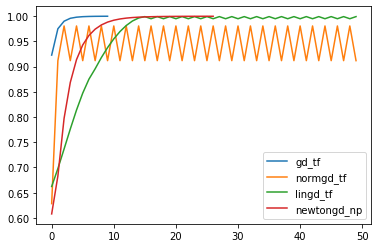

In [84]:
plt.plot(gdfs, label='gd_tf')
plt.plot(ngdfs[:50], label='normgd_tf')
plt.plot(lngdfs[:50], label='lingd_tf')
plt.plot(mfs[:50], label='newtongd_np')
#plt.plot([-np.log(s)/10 for s in states])

plt.legend(loc='lower right')

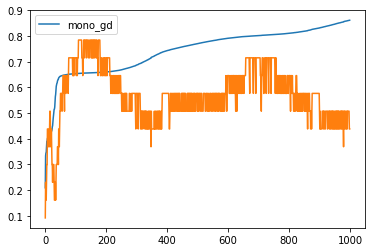

In [36]:
#plt.plot(gdfs, label='norm_gd')
plt.plot(mfs, label='mono_gd')
plt.plot([-np.log(s)/10 for s in states])

plt.legend(loc='upper left')

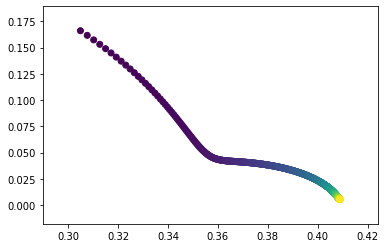

In [55]:
plt.scatter(gdfs, gddfs, c=range(len(gdfs)))

In [273]:
def dynamic_sampling(dim, h_generator, source, target):
    opt = lambda h : abs(np.vdot(np.matmul(sc.linalg.expm(1j * h), source), target))
    diff = lambda d : (opt(h + eps * d) - opt(h)) / eps
    
    eps = 0.001
    step = 0.01
    
    samples = 1
    opt_samples = 1000
    
    params = h_generator()
    fs = []
    dfs = []
    for _ in tqdm(range(samples)):
        h = sum([p * v for p, v in zip(params, np.random.randn(len(params)))])
        with tqdm() as t:
            for _ in range(opt_samples):
                fs.append(opt(h))
                df = np.array([diff(p) for p in params])
                dfs.append(np.linalg.norm(df))
                
                if fs[-1] > 0.99:
                    break
                    
                if np.linalg.norm(df) == 0:
                    print('local point')
                    df = np.random.randn(len(df))

                h += step * sum([p * d for p, d in zip(params, df)]) / (np.linalg.norm(df))
                t.update()
                t.set_description("fidelity: %f" % fs[-1])
    return fs, dfs

In [274]:
target = np.random.randn(dim) + 1j * np.random.randn(dim)
target /= np.linalg.norm(target)
fdist, dfdist = dynamic_sampling(dim, h_generator_np, source, target)

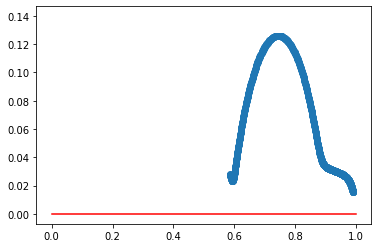

In [275]:
plt.scatter(fdist, dfdist)
plt.plot([0,1], [0,0], c='r')

In [187]:
max(zip(fdist, dfdist), key=lambda x : x[1])

(0.537297085249586, 0.07827534264085992)

In [198]:
0.0782 / 0.5 ** 2

0.3128